## Task 1: Consumer-Level Flexibility Models

#### Imports

In [2]:
import json
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

#### Data

In [ ]:
DATA_DIR = Path("data/question_1a")

#### Helpers

In [16]:
def load_inputs(data_dir=DATA_DIR):
    with open(data_dir / "appliance_params.json") as f:
        appliance_params = json.load(f)
    with open(data_dir / "bus_params.json") as f:
        bus_params = json.load(f)[0]
    with open(data_dir / "consumer_params.json") as f:
        consumer_params = json.load(f)[0]
    with open(data_dir / "DER_production.json") as f:
        der_prod = json.load(f)[0]
    with open(data_dir / "usage_preference.json") as f:
        usage_pref = json.load(f)[0]
    return appliance_params, bus_params, consumer_params, der_prod, usage_pref

def prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref):
    T = len(bus_params["energy_price_DKK_per_kWh"])
    price = np.array(bus_params["energy_price_DKK_per_kWh"])
    imp_tariff = np.full(T, bus_params["import_tariff_DKK/kWh"])
    exp_tariff = np.full(T, bus_params["export_tariff_DKK/kWh"])

    pv_power = next(d["max_power_kW"] for d in appliance_params["DER"] if d["DER_type"] == "PV")
    pv_profile = np.array(der_prod["hourly_profile_ratio"])
    P_pv = pv_power * pv_profile

    load_prefs = usage_pref["load_preferences"][0]
    L_min = load_prefs["min_total_energy_per_day_hour_equivalent"]

    l_max_hour = next(l["max_load_kWh_per_hour"] for l in appliance_params["load"])
    return dict(T=T, price=price, imp_tariff=imp_tariff, exp_tariff=exp_tariff,
                P_pv=P_pv, L_min=L_min, l_max_hour=l_max_hour)

def make_scenarios(base):
    scenarios = {}
    # Base
    scenarios["Base"] = dict(price=base["price"], imp=base["imp_tariff"], exp=base["exp_tariff"])
    # Constant price
    scenarios["Const price"] = dict(price=np.full(base["T"], base["price"].mean()),
                                    imp=base["imp_tariff"], exp=base["exp_tariff"])
    # Net metering
    scenarios["Net metering"] = dict(price=base["price"], imp=np.zeros(base["T"]), exp=np.zeros(base["T"]))
    # No profitable export
    scenarios["No export"] = dict(price=base["price"], imp=base["imp_tariff"],
                                  exp=base["price"]+0.01)
    # Evening spike
    spike = base["price"].copy()
    spike[18:22] *= 2.0
    scenarios["Spike"] = dict(price=spike, imp=base["imp_tariff"], exp=base["exp_tariff"])
    return scenarios


In [186]:
class InputData:
    def __init__(self, VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense):
        self.VARIABLES = VARIABLES
        self.objective_coeff = objective_coeff
        self.constraints_coeff = constraints_coeff
        self.constraints_rhs = constraints_rhs
        self.constraints_sense = constraints_sense

class LP_OptimizationProblem:

    def __init__(self, input_data: InputData): 
        self.data = input_data 
        self.results = type("Expando", (), {})()  # simple dummy expando
        self._build_model() 
    
    def _build_variables(self):
        self.variables = {v: self.model.addVar(lb=0, name=v) for v in self.data.VARIABLES}
    
    def _build_constraints(self):
        self.constraints = []
        for i in range(len(self.data.constraints_rhs)):
            lhs = gp.quicksum(self.data.constraints_coeff[v][i] * self.variables[v] for v in self.data.VARIABLES)
            constr = self.model.addLConstr(lhs,
                                           self.data.constraints_sense[i],
                                           self.data.constraints_rhs[i],
                                           name=f"constr[{i}]")
            self.constraints.append(constr)

    def _build_objective_function(self):
        objective = gp.quicksum(self.data.objective_coeff[v] * self.variables[v] for v in self.data.VARIABLES)
        self.model.setObjective(objective, GRB.MINIMIZE)

    def _build_model(self):
        self.model = gp.Model(name='Consumer Flexibility')
        self._build_variables()
        self._build_objective_function()
        self._build_constraints()
        self.model.update()
    
    def _save_results(self):
        self.results.objective_value = self.model.ObjVal
        self.results.variables = {v: self.variables[v].X for v in self.data.VARIABLES}
        self.results.duals = {f"constr[{i}]": self.constraints[i].Pi for i in range(len(self.constraints))}

    def run(self):
        self.model.optimize()
        if self.model.status == GRB.OPTIMAL:
            self._save_results()
        else:
            print(f"optimization of {self.model.ModelName} was not successful")
    
    def display_results(self):
        print("\n-------------------   RESULTS  -------------------")
        print("Optimal objective value:", self.results.objective_value)
        print("Optimal variable values:", self.results.variables)
        print("Optimal dual values:", self.results.duals)

In [193]:
import gurobipy as gp
from gurobipy import GRB

class InputData:
    def __init__(self, VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense):
        self.VARIABLES = VARIABLES
        self.objective_coeff = objective_coeff
        self.constraints_coeff = constraints_coeff
        self.constraints_rhs = constraints_rhs
        self.constraints_sense = constraints_sense

class LP_OptimizationProblem:

    def __init__(self, input_data: InputData): 
        self.data = input_data 
        self.results = type("Expando", (), {})()  # simple dummy expando
        self._build_model() 
    
    def _build_variables(self):
        # all variables are nonnegative
        self.variables = {v: self.model.addVar(lb=0, name=v) for v in self.data.VARIABLES}
    
    def _build_constraints(self):
        self.constraints = []
        for i in range(len(self.data.constraints_rhs)):
            lhs = gp.quicksum(self.data.constraints_coeff[v][i] * self.variables[v] 
                              for v in self.data.VARIABLES)
            constr = self.model.addLConstr(lhs,
                                           self.data.constraints_sense[i],
                                           self.data.constraints_rhs[i],
                                           name=f"constr[{i}]")
            self.constraints.append(constr)

    def _build_objective_function(self):
        objective = gp.quicksum(self.data.objective_coeff[v] * self.variables[v] 
                                for v in self.data.VARIABLES)
        self.model.setObjective(objective, GRB.MINIMIZE)

    def _build_model(self):
        self.model = gp.Model(name='Consumer Flexibility')
        self._build_variables()
        self._build_objective_function()
        self._build_constraints()
        self.model.update()
    
    def _save_results(self):
        self.results.objective_value = self.model.ObjVal
        self.results.variables = {v: self.variables[v].X for v in self.data.VARIABLES}
        # dual values: shadow prices of constraints
        self.results.duals = {f"constr[{i}]": self.constraints[i].Pi 
                              for i in range(len(self.constraints))}

    def run(self):
        self.model.optimize()
        if self.model.status == GRB.OPTIMAL:
            self._save_results()
        else:
            print(f"Optimization of {self.model.ModelName} was not successful")
    
    def display_results(self):
        print("\n-------------------   RESULTS  -------------------")
        print("Optimal objective value:", self.results.objective_value)
        print("Optimal variable values:", self.results.variables)
        print("Optimal dual values:", self.results.duals)


def build_input_data(base, scenario):
    T = base["T"]
    price = scenario["price"]   # hourly prices
    imp   = scenario["imp"]     # import tariffs
    exp   = scenario["exp"]     # export tariffs
    P_pv  = base["P_pv"]        # PV availability
    L_min = base["L_min"]       # minimum daily consumption

    # Variables: l_t, p_t, e_t, s_t, c_t for each hour
    VARIABLES = []
    for t in range(T):
        VARIABLES += [f"l[{t}]", f"p[{t}]", f"e[{t}]", f"s[{t}]", f"c[{t}]"]

    # Objective coefficients
    objective_coeff = {v: 0 for v in VARIABLES}
    for t in range(T):
        # imports cost π+τ_imp
        objective_coeff[f"e[{t}]"] = price[t] + imp[t]
        # exports revenue π−τ_exp (negative cost)
        objective_coeff[f"s[{t}]"] = -(price[t] - exp[t])
        # l, p, c have zero direct cost

    # Constraint coefficients
    constraints_coeff = {v: [] for v in VARIABLES}
    constraints_rhs = []
    constraints_sense = []

    # (1) Daily minimum consumption: sum l_t >= L_min
    for v in VARIABLES:
        constraints_coeff[v].append(1.0 if v.startswith("l[") else 0.0)
    constraints_rhs.append(L_min)
    constraints_sense.append(GRB.GREATER_EQUAL)

    # (2) Hourly load balance: l_t = p_t + e_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"p[{t}]": coeff = -1.0
            elif v == f"e[{t}]": coeff = -1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (3) PV split: p_t + s_t + c_t = P^{PV}_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"p[{t}]": coeff = 1.0
            elif v == f"s[{t}]": coeff = 1.0
            elif v == f"c[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(P_pv[t])
        constraints_sense.append(GRB.EQUAL)

    return InputData(VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense)

In [194]:
appliance_params, bus_params, consumer_params, der_prod, usage_pref = load_inputs()
base = prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref)
scenarios = make_scenarios(base)

#### Analysis and Visualizations

In [195]:
def results_to_dataframe(results, T):
    """Convert results.variables into a tidy DataFrame."""
    df = pd.DataFrame(index=range(T))
    for var, value in results.variables.items():
        # var looks like "l[3]" or "e[10]"
        name, idx = var.split("[")
        t = int(idx.strip("]"))
        df.loc[t, name] = value
    return df.fillna(0.0)

def plot_hourly_flows_with_prices(df, scenario_name, duals=None,
                                  price=None, alpha=None, beta=None, ylim=(0,3)):
    rename = {
        "l": "Load",
        "p": "PV self-consumed",
        "e": "Grid imports",
        "s": "PV exported",
        "c": "PV curtailed",
    }
    df_named = df.rename(columns=rename)

    # Compute total PV generation
    df_named["PV generation"] = (
        df_named["PV self-consumed"] 
        + df_named["PV exported"] 
        + df_named["PV curtailed"]
    )

    hours = df_named.index
    width = 0.25
    bar_alpha = 0.85

    plt.rcParams.update({
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    })

    fig, ax1 = plt.subplots(figsize=(14,6))

    # --- Group 1: PV generation (stacked) ---
    ax1.bar(hours - width, df_named["PV self-consumed"], width,
            label="PV self-consumed", color="gold", alpha=bar_alpha)
    ax1.bar(hours - width, df_named["PV exported"], width,
            bottom=df_named["PV self-consumed"], label="PV exported",
            color="forestgreen", alpha=bar_alpha)
    ax1.bar(hours - width, df_named["PV curtailed"], width,
            bottom=df_named["PV self-consumed"]+df_named["PV exported"],
            label="PV curtailed", color="lightgray", alpha=bar_alpha)

    # --- PV frame (outline for total generation) ---
    ax1.bar(hours - width, df_named["PV generation"], width,
            fill=False, edgecolor="black", linewidth=1.5,
            label="Total PV generation")

    # --- Group 2: Load (center) ---
    ax1.bar(hours, df_named["Load"], width,
            label="Load", color="royalblue", alpha=bar_alpha)

    # --- Group 3: Imports (right) ---
    ax1.bar(hours + width, df_named["Grid imports"], width,
            label="Grid imports", color="firebrick", alpha=bar_alpha)

    # --- Axis formatting ---
    ax1.set_title(f"Energy flows and prices – {scenario_name}")
    ax1.set_xlabel("Hour of day")
    ax1.set_ylabel("Energy (kWh)")
    ax1.set_ylim(ylim)
    ax1.set_xlim(-0.5, len(hours)-0.5)
    ax1.set_xticks(range(len(hours)))
    ax1.grid(True, which="both", axis="y", linestyle="--", alpha=0.6)

    # --- Second axis: prices ---
    if duals is not None:
        ax2 = ax1.twinx()
        p_int = -pd.Series(duals, index=hours)
        ax2.plot(hours, p_int, marker="x", linestyle="--",
                 color="purple", linewidth=2, label="Internal price (−λ)")

        if price is not None:
            ax2.plot(hours, price, marker="o", linestyle=":",
                     color="dimgray", linewidth=2, label="Market price π")
        if alpha is not None:
            ax2.plot(hours, alpha, linestyle="--",
                     color="red", linewidth=2, label="Import cost α")
        if beta is not None:
            ax2.plot(hours, beta, linestyle="-.",
                     color="green", linewidth=2, label="Export value β")

        ax2.set_ylabel("Price (DKK/kWh)")
        ax2.tick_params(axis='y', labelcolor="black")

        # Merge legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1+lines2, labels1+labels2,
                   loc="upper center", bbox_to_anchor=(0.5, -0.18),
                   ncol=5, frameon=False)
    else:
        ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18),
                   ncol=5, frameon=False)

    plt.tight_layout()
    plt.show()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0xab3ac14a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 48 rows and 110 columns
Presolve time: 0.00s
Presolved: 1 rows, 10 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.6140000e+00   3.610000e+00   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
       2   -6.3725000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective -6.372500000e+00

-------------------   RESULTS  -------------------
Optimal objective value: -6.3725000000000005
Optimal variable values: {'l[0]':

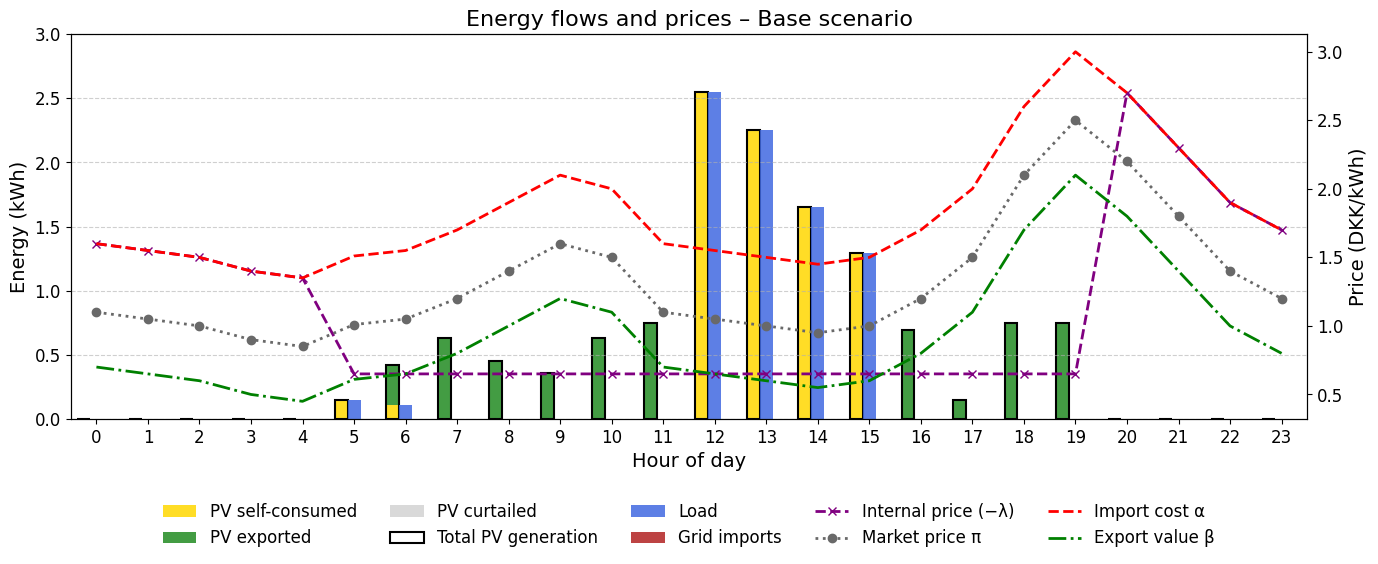

sum of load: 7.999999999999999


In [209]:
input_data = build_input_data(base, scenarios["Base"])
problem = LP_OptimizationProblem(input_data)
problem.run()
problem.display_results()

df = results_to_dataframe(problem.results, base["T"])
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

plot_hourly_flows_with_prices(
    df,
    "Base scenario",
    #pv_profile=base["P_pv"],
    duals=duals,
    price=scenarios["Base"]["price"],
    alpha=scenarios["Base"]["price"]+scenarios["Base"]["imp"],
    beta=scenarios["Base"]["price"]-scenarios["Base"]["exp"]
)
print("sum of load:", df["l"].sum())

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0xab3ac14a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 48 rows and 110 columns
Presolve time: 0.00s
Presolved: 1 rows, 10 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.6140000e+00   3.610000e+00   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
       2   -6.3725000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective -6.372500000e+00


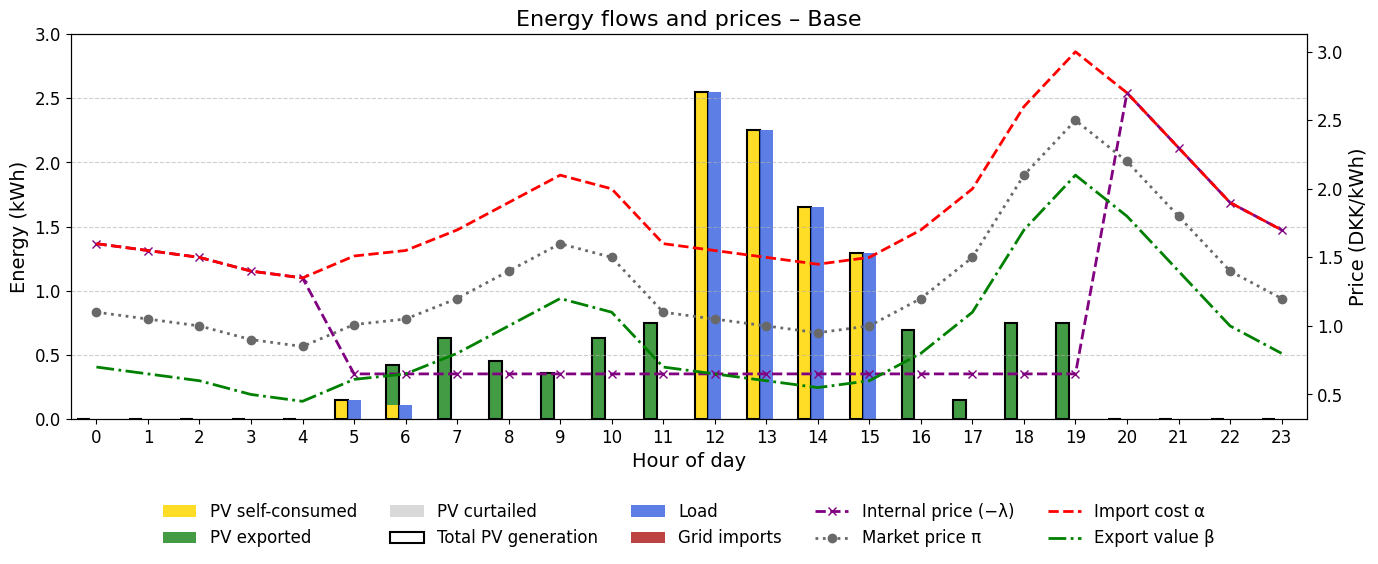

sum of load: 7.999999999999999


In [208]:
# --- Base scenario ---
scenario_name = "Base"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data(base, sc)

# 2) Run optimization
problem = LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

# 5) Plot
plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"]
)
print("sum of load:", df["l"].sum())

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0xce0c7b89
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 48 rows and 118 columns
Presolve time: 0.00s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.0278417e+00   0.000000e+00   0.000000e+00      0s
       0   -5.0278417e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -5.027841667e+00


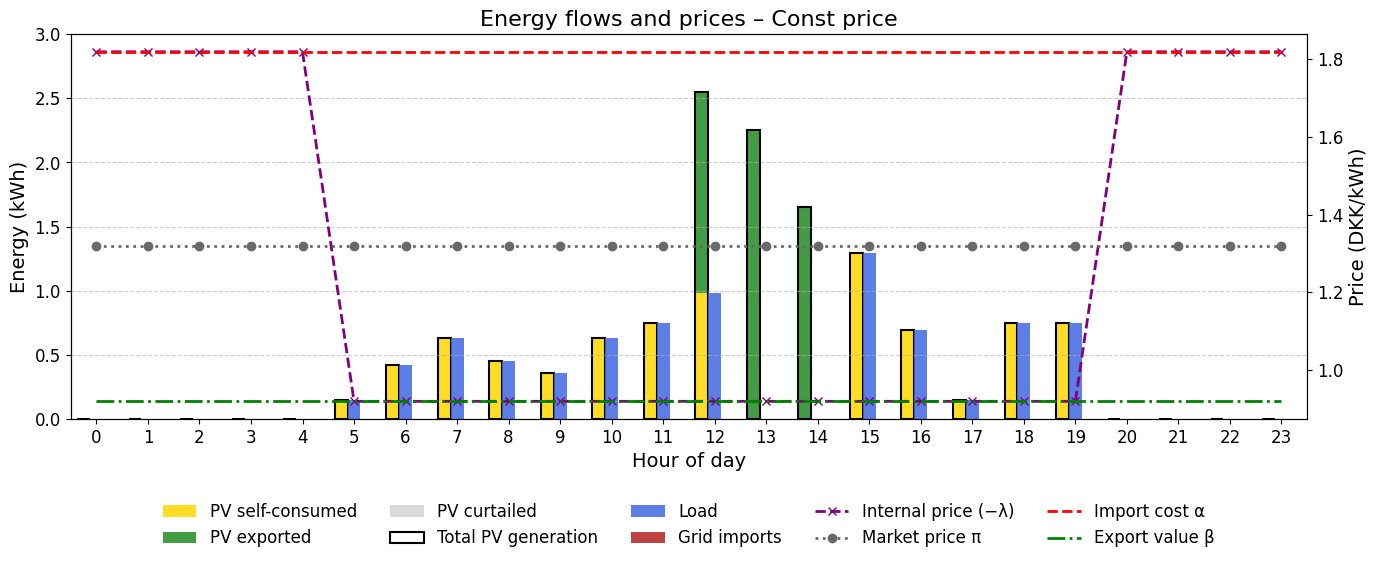

sum of load: 8.0


In [203]:
# --- Constant price scenario ---
scenario_name = "Const price"
sc = scenarios[scenario_name]

input_data = build_input_data(base, sc)
problem = LP_OptimizationProblem(input_data)
problem.run()
df = results_to_dataframe(problem.results, base["T"])
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

plot_hourly_flows_with_prices(
    df,
    scenario_name,
    #pv_profile=base["P_pv"],
    duals=duals,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"]
)

print("sum of load:", df["l"].sum())

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x1993e6e7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 49 rows and 120 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.8125000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -9.812500000e+00


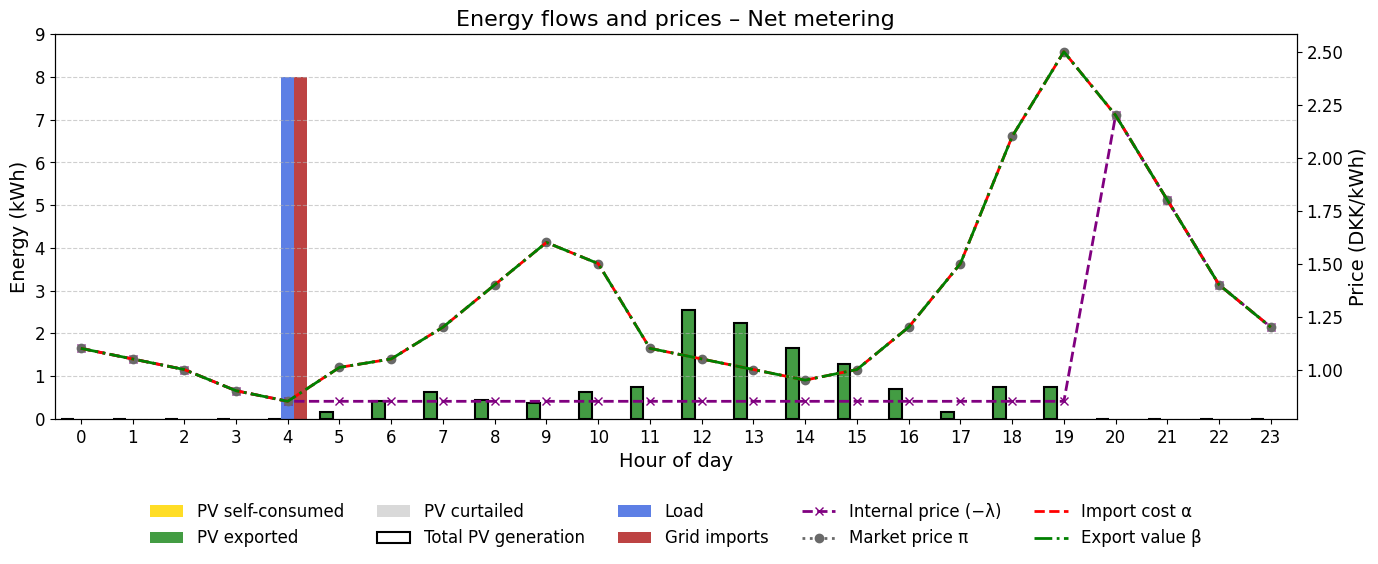

sum of load: 8.0


In [205]:
# --- Net metering scenario ---
scenario_name = "Net metering"
sc = scenarios[scenario_name]

input_data = build_input_data(base, sc)
problem = LP_OptimizationProblem(input_data)
problem.run()
df = results_to_dataframe(problem.results, base["T"])
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

plot_hourly_flows_with_prices(
    df,
    scenario_name,
    #pv_profile=base["P_pv"],
    duals=duals,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    ylim=(0,9)
)
print("sum of load:", df["l"].sum())

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x6ed9d015
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 49 rows and 120 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  0.000000000e+00


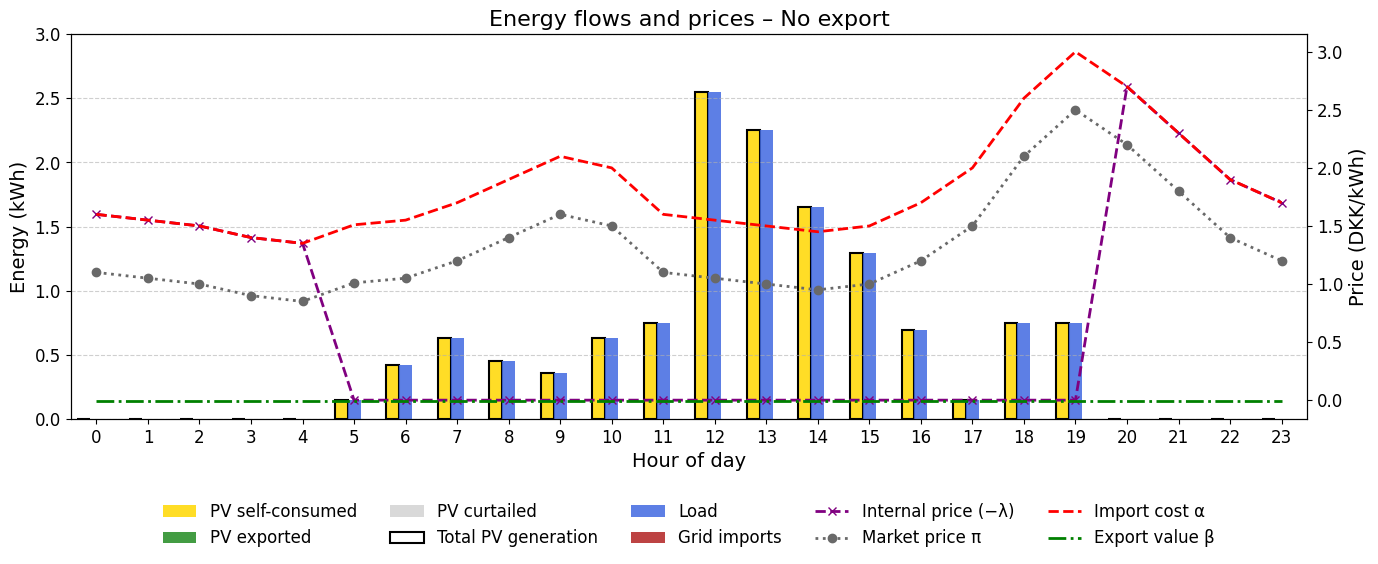

sum of load: 13.469999999999999


In [206]:
# --- No export scenario ---
scenario_name = "No export"
sc = scenarios[scenario_name]

input_data = build_input_data(base, sc)
problem = LP_OptimizationProblem(input_data)
problem.run()
df = results_to_dataframe(problem.results, base["T"])
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

plot_hourly_flows_with_prices(
    df,
    scenario_name,
    #pv_profile=base["P_pv"],
    duals=duals,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"]
)
print("sum of load:", df["l"].sum())

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0xef0653fb
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 48 rows and 110 columns
Presolve time: 0.00s
Presolved: 1 rows, 10 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1064000e+01   3.610000e+00   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
       2   -9.8225000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective -9.822500000e+00


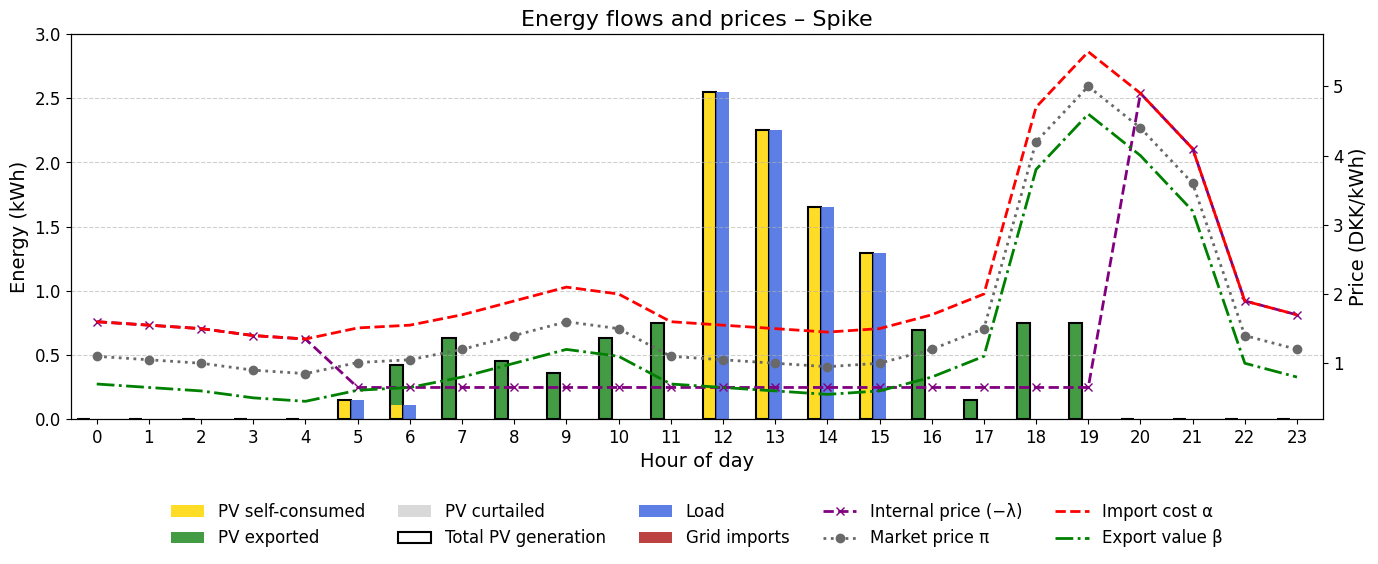

sum of load: 7.999999999999999


In [207]:
# --- Evening spike scenario ---
scenario_name = "Spike"
sc = scenarios[scenario_name]

input_data = build_input_data(base, sc)
problem = LP_OptimizationProblem(input_data)
problem.run()
df = results_to_dataframe(problem.results, base["T"])
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

plot_hourly_flows_with_prices(
    df,
    scenario_name,
    #pv_profile=base["P_pv"],
    duals=duals,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"]
)
print("sum of load:", df["l"].sum())